In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import pytz

import pandas as pd
import matplotlib.pyplot as plt

from utils.download_data import download_themis_data
from utils.process_data import *
from utils.plot_data import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# base_url = "https://themis.ssl.berkeley.edu/data/themis/tha/l2/sst/2014/"
# start_date = "20140701"
# end_date = "20141231"
# download_dir = "data/tha/sst_july_dec_2014"

# download_themis_data(base_url, start_date, end_date, download_dir)

In [3]:
cutoff_date = datetime(2015, 1, 1, tzinfo=pytz.UTC).timestamp()

In [ ]:
raw_fgm_matrix = process_fgm("data/tha/fgm_july_dec_2014")
raw_state_matrix = process_state("data/tha/state_july_dec_2014")
raw_eflux_matrix, raw_iflux_matrix = process_sst("data/tha/sst_july_dec_2014")

In [5]:
interpolated_state = interpolate_columns(raw_state_matrix, raw_fgm_matrix['Time'], ['GSM_x', 'GSM_y', 'GSM_z'])
interpolated_eflux = interpolate_columns(raw_eflux_matrix, raw_fgm_matrix['Time'], ['E_flux_c5'])
interpolated_iflux = interpolate_columns(raw_iflux_matrix, raw_fgm_matrix['Time'], ['I_flux_c5'])

interpolated_data = {**interpolated_state, **interpolated_eflux, **interpolated_iflux}

final_matrix = pd.concat([raw_fgm_matrix.reset_index(drop=True), pd.DataFrame(interpolated_data)], axis=1)

final_matrix.insert(1, 'Epoch_time', final_matrix['Time'].copy())
final_matrix = final_matrix[final_matrix['Epoch_time'] < cutoff_date]
final_matrix['Time'] = pd.to_datetime(final_matrix['Time'], unit='s', utc=True)

In [6]:
final_matrix['dBz6sec'] = final_matrix['Bz'].shift(-1) - final_matrix['Bz'].shift(1)
final_matrix['dFe'] = final_matrix['E_flux_c5'].shift(-1) - final_matrix['E_flux_c5'].shift(1)
final_matrix['dFi'] = final_matrix['I_flux_c5'].shift(-1) - final_matrix['I_flux_c5'].shift(1)

final_matrix['rel_dFe'] = final_matrix['dFe'] / ((final_matrix['E_flux_c5'].shift(-1) + final_matrix['E_flux_c5'].shift(1)) / 2)
final_matrix['rel_dFi'] = final_matrix['dFi'] / ((final_matrix['I_flux_c5'].shift(-1) + final_matrix['I_flux_c5'].shift(1)) / 2)

In [7]:
final_matrix

,Time,Epoch_time,Bx,By,Bz,GSM_x,GSM_y,GSM_z,E_flux_c5,I_flux_c5,dBz6sec,dFe,dFi,rel_dFe,rel_dFi
0,2014-07-01 00:04:29.472872972+00:00,1.404173e+09,32.705685,-4.197578,75.724640,22348.100094,-39559.904164,-10343.821143,328731.479708,8875.974443,NaN,NaN,NaN,NaN,NaN
1,2014-07-01 00:04:32.399597168+00:00,1.404173e+09,32.826534,-4.368367,75.815819,22348.948672,-39552.346509,-10342.184483,335691.095578,8814.399717,0.059776,7328.265944,-965.225459,0.022047,-0.114999
2,2014-07-01 00:04:35.326321602+00:00,1.404173e+09,32.873180,-4.286692,75.784416,22349.797251,-39544.788853,-10340.547823,336059.745652,7910.748983,0.051819,-5725.912978,-1593.786628,-0.017204,-0.198788
3,2014-07-01 00:04:38.253045797+00:00,1.404173e+09,32.876461,-4.279731,75.867638,22350.645829,-39537.231197,-10338.911163,329965.182600,7220.613089,0.099014,-3021.129061,-220.824705,-0.009030,-0.028310
4,2014-07-01 00:04:41.179769993+00:00,1.404173e+09,32.853149,-4.318972,75.883430,22351.494408,-39529.673542,-10337.274503,333038.616591,7689.924279,-0.051598,3473.702134,1342.427752,0.010472,0.170104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485783,2014-12-31 23:59:48.034995794+00:00,1.420070e+09,-7.329637,-27.916031,16.939493,-6794.074975,59074.862956,16493.217443,17794.830067,701.760582,-0.075235,-275.043396,-1.080079,-0.015456,-0.001539
5485784,2014-12-31 23:59:50.922860622+00:00,1.420070e+09,-7.302068,-27.800406,16.913635,-6797.812090,59078.833206,16493.141863,17657.308143,701.220542,-0.039831,-275.043396,-1.080079,-0.015577,-0.001540
5485785,2014-12-31 23:59:53.810715914+00:00,1.420070e+09,-7.240098,-27.833035,16.899662,-6801.549193,59082.803443,16493.066282,17519.786672,700.680504,0.056929,-275.042941,-1.080077,-0.015699,-0.001541
5485786,2014-12-31 23:59:56.698571205+00:00,1.420070e+09,-7.247959,-27.618179,16.970564,-6805.286296,59086.773680,16492.990701,17382.265201,700.140465,0.104691,-275.043407,-1.080079,-0.015823,-0.001543


## Plots

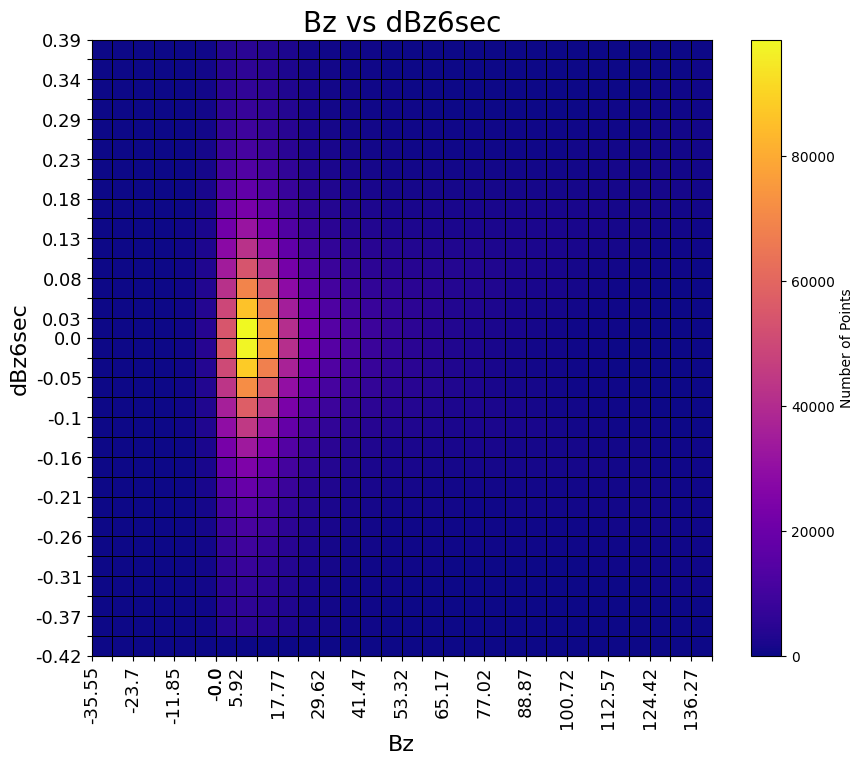

In [8]:
plot_2d_histogram(dataframe=final_matrix, q1='Bz', q2='dBz6sec', xlab='Bz', ylab='dBz6sec',
                  remove_outliers=True, cmap='plasma', dpi=100, log_scale=False)

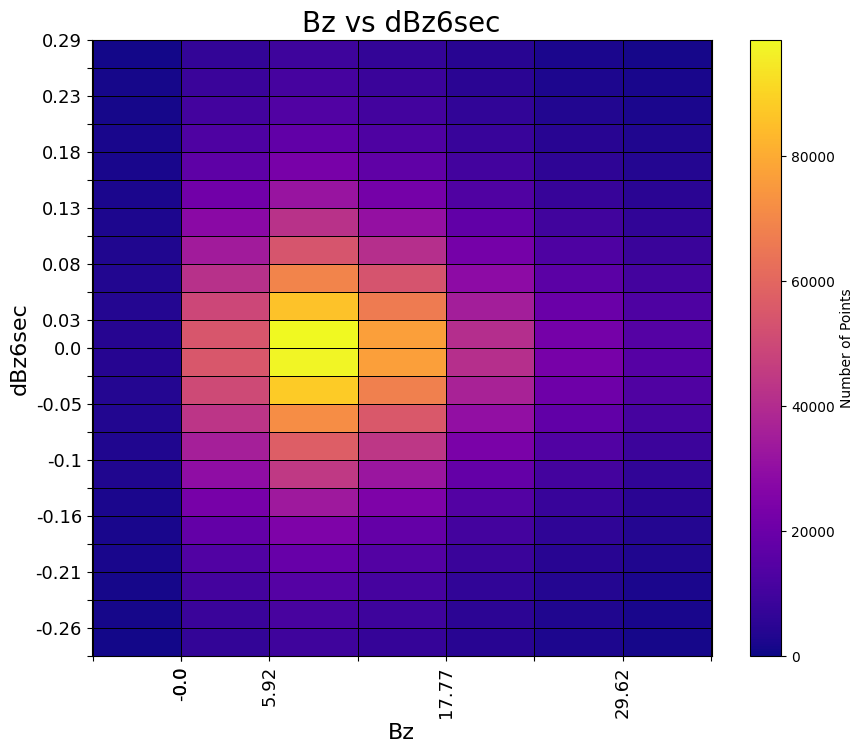

In [9]:
plot_2d_histogram(dataframe=final_matrix, q1='Bz', q2='dBz6sec', xlab='Bz', ylab='dBz6sec', dpi=100,
                  remove_outliers=True, cmap='plasma', xlim=(-6, 35.6), ylim=(-0.2869, 0.2869))

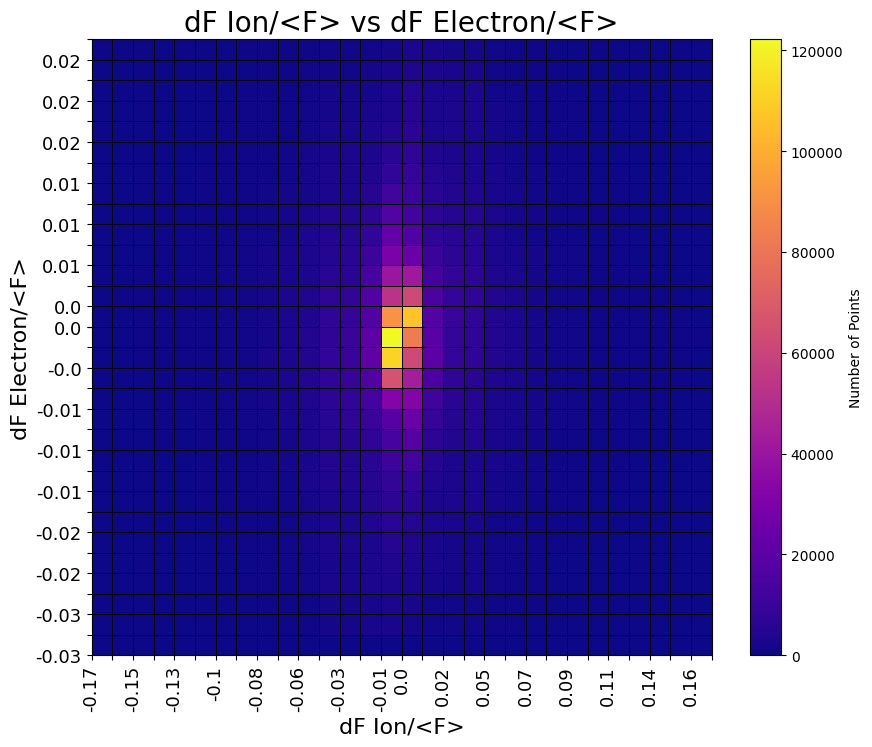

In [10]:
plot_2d_histogram(dataframe=final_matrix, q1='rel_dFi', q2='rel_dFe', xlab='dF Ion/<F>', ylab='dF Electron/<F>',
                  remove_outliers=True, cmap='plasma', dpi=100)

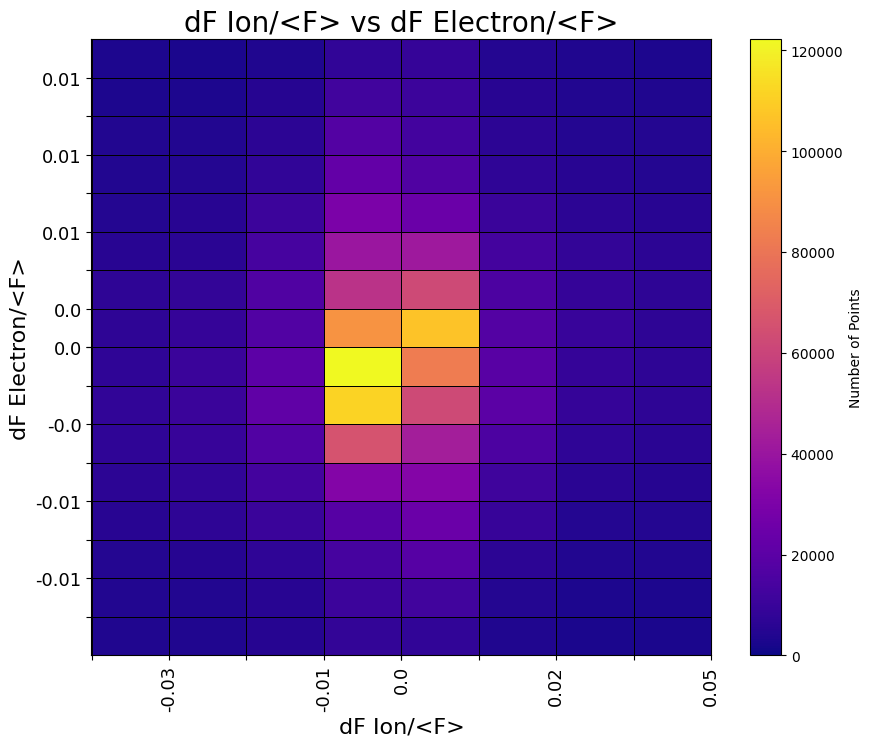

In [11]:
plot_2d_histogram(dataframe=final_matrix, q1='rel_dFi', q2='rel_dFe', xlab='dF Ion/<F>', ylab='dF Electron/<F>', 
                  remove_outliers=True, cmap='plasma', xlim=(-0.0459, 0.0459), ylim=(-0.01429, 0.01429),
                  dpi=100)

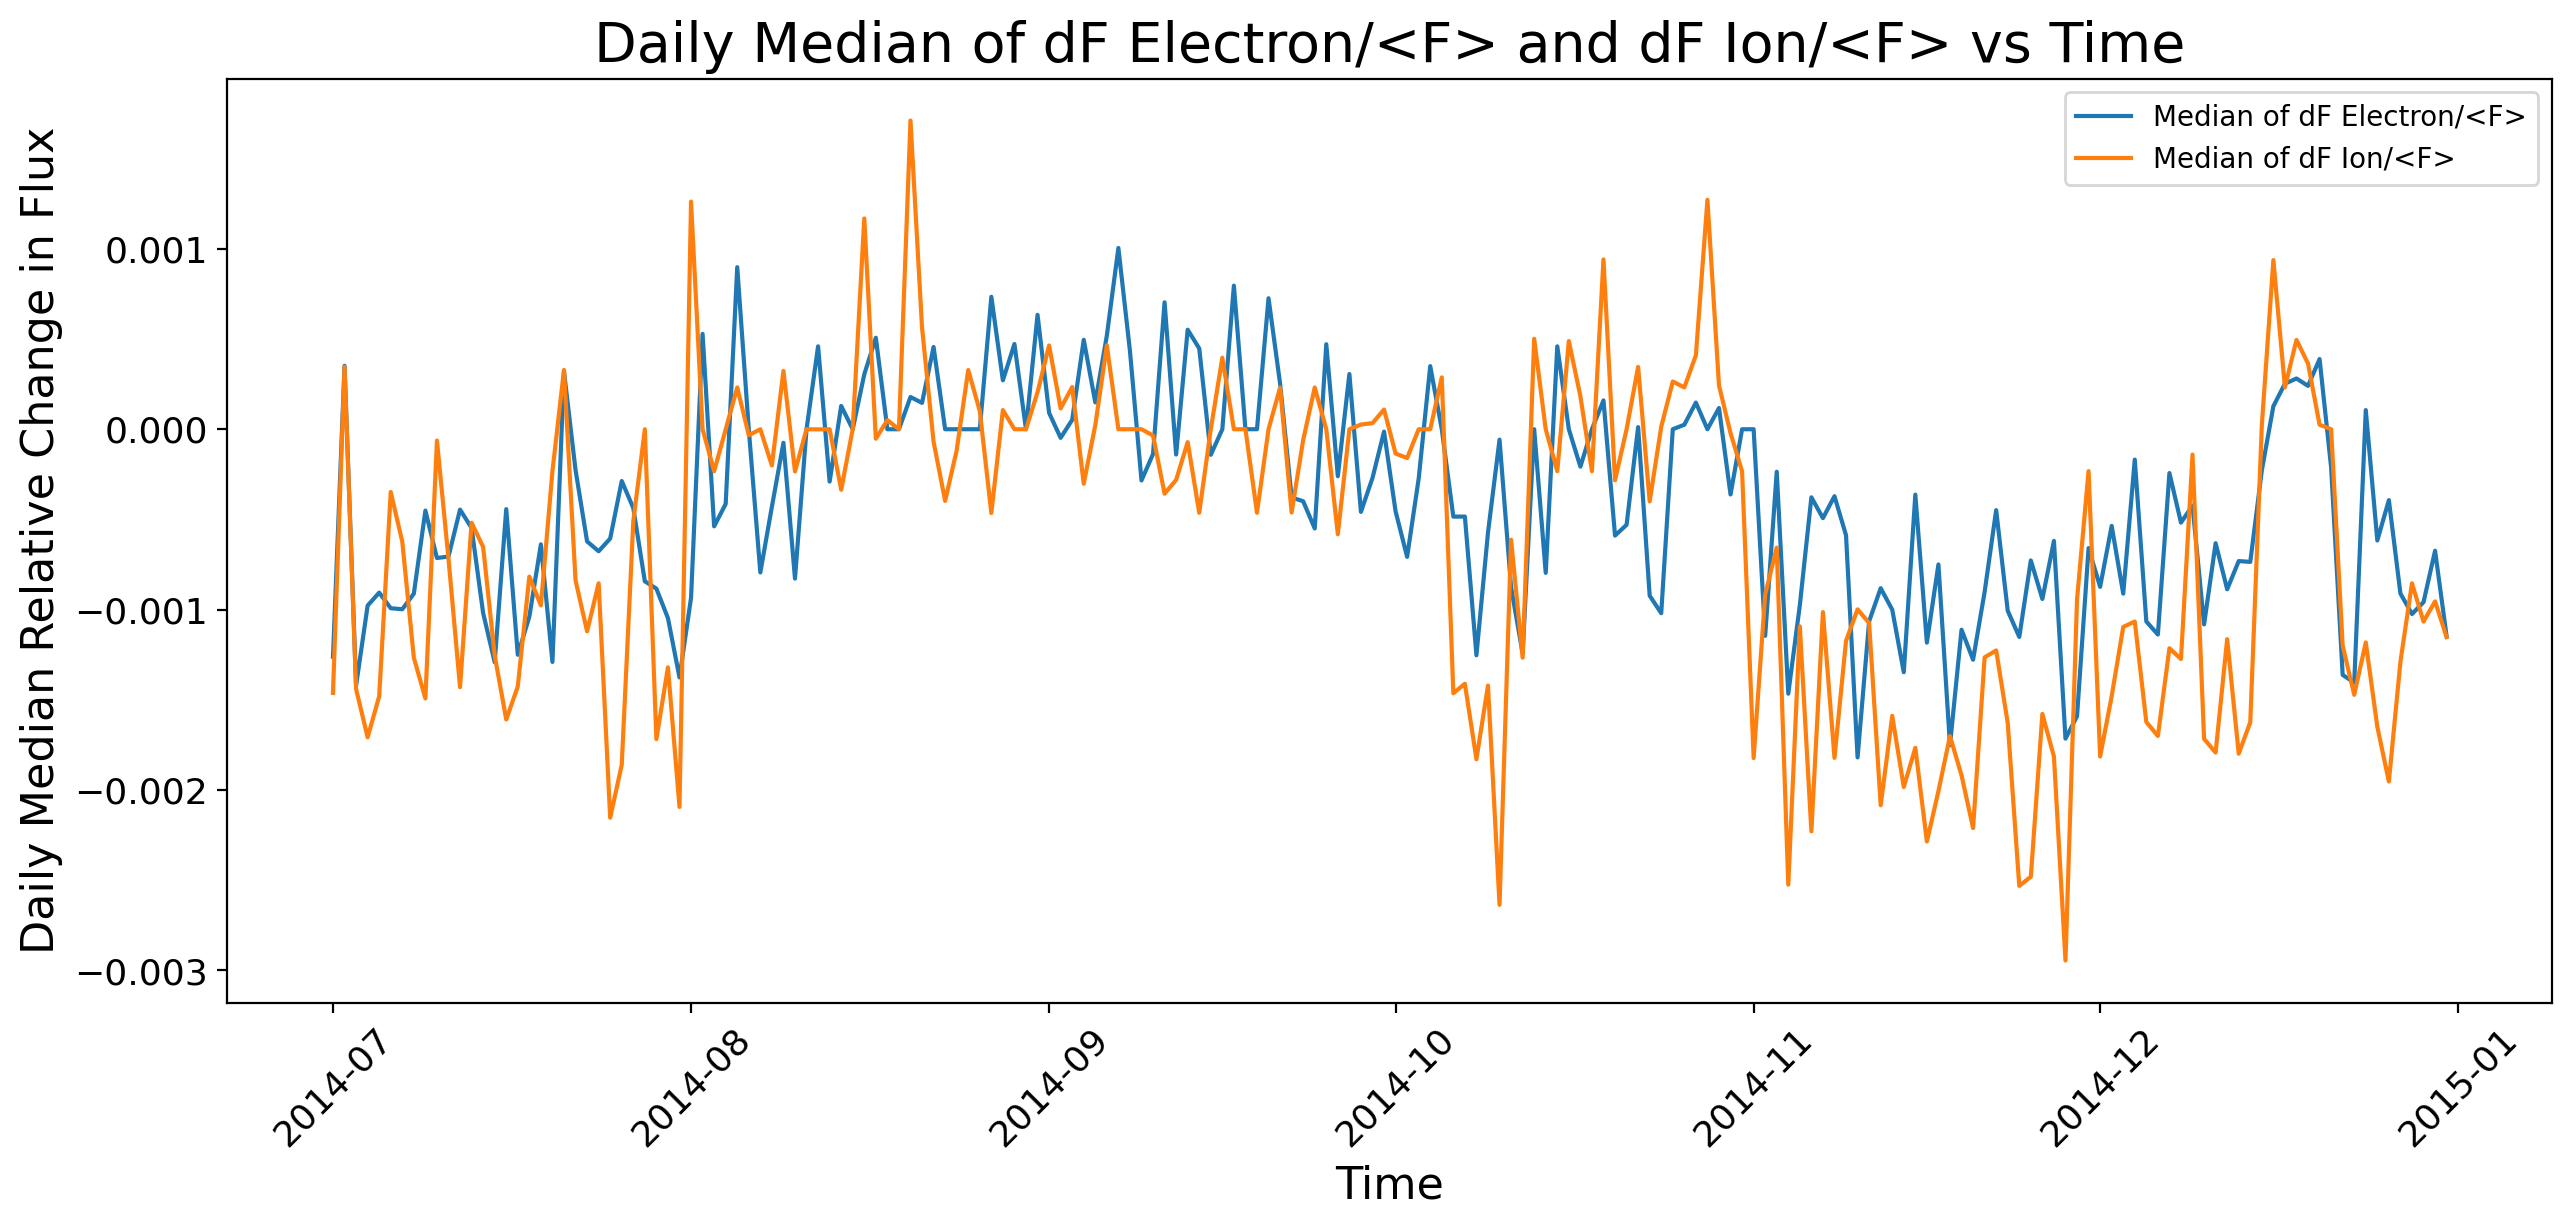

In [12]:
final_matrix.index = final_matrix['Time']
resampled_df = final_matrix.resample('D').median()

plt.figure(figsize=(15, 6), dpi=200)
plt.plot(resampled_df.index, resampled_df['rel_dFe'], label='Median of dF Electron/<F>')
plt.plot(resampled_df.index, resampled_df['rel_dFi'], label='Median of dF Ion/<F>')

plt.title(f'Daily Median of dF Electron/<F> and dF Ion/<F> vs Time', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel(f'Daily Median Relative Change in Flux', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.legend()
plt.show()

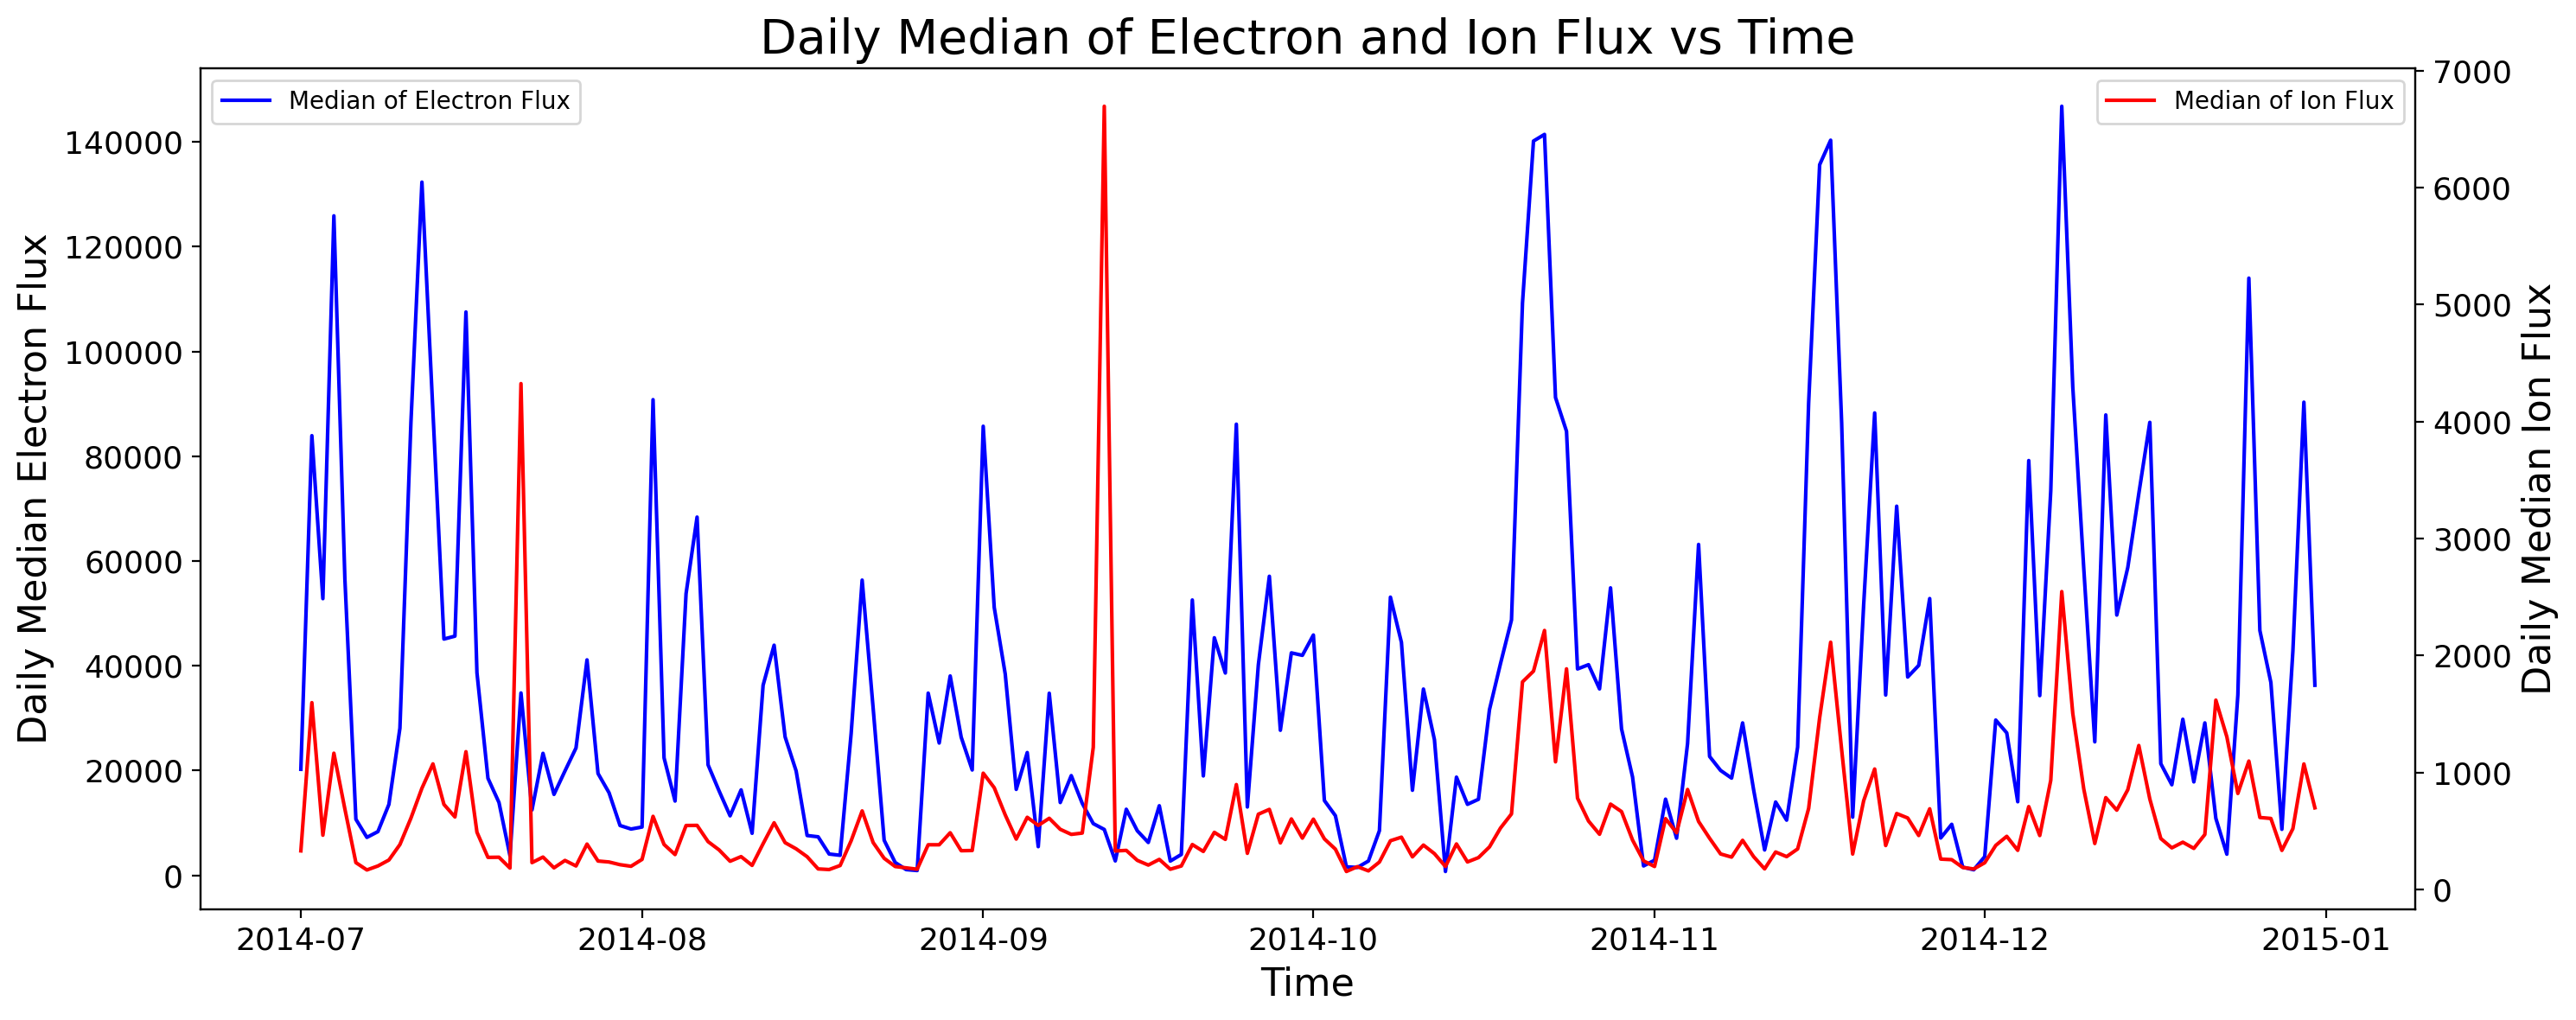

In [13]:
final_matrix.index = final_matrix['Time']
resampled_df = final_matrix.resample('D').median()
fig, ax1 = plt.subplots(figsize=(15, 6), dpi=200)

ax1.plot(resampled_df.index, resampled_df['E_flux_c5'], label='Median of Electron Flux', color='b')
ax1.set_xlabel('Time', fontsize=16)
ax1.set_ylabel('Daily Median Electron Flux', color='black', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black', labelsize=13)
ax1.tick_params(axis='x', labelcolor='black', labelsize=13)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(resampled_df.index, resampled_df['I_flux_c5'], label='Median of Ion Flux', color='r')
ax2.set_ylabel('Daily Median Ion Flux', color='black', fontsize=16)
ax2.tick_params(axis='y', labelcolor='black', labelsize=13)
ax2.legend()

plt.title('Daily Median of Electron and Ion Flux vs Time', fontsize=20)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

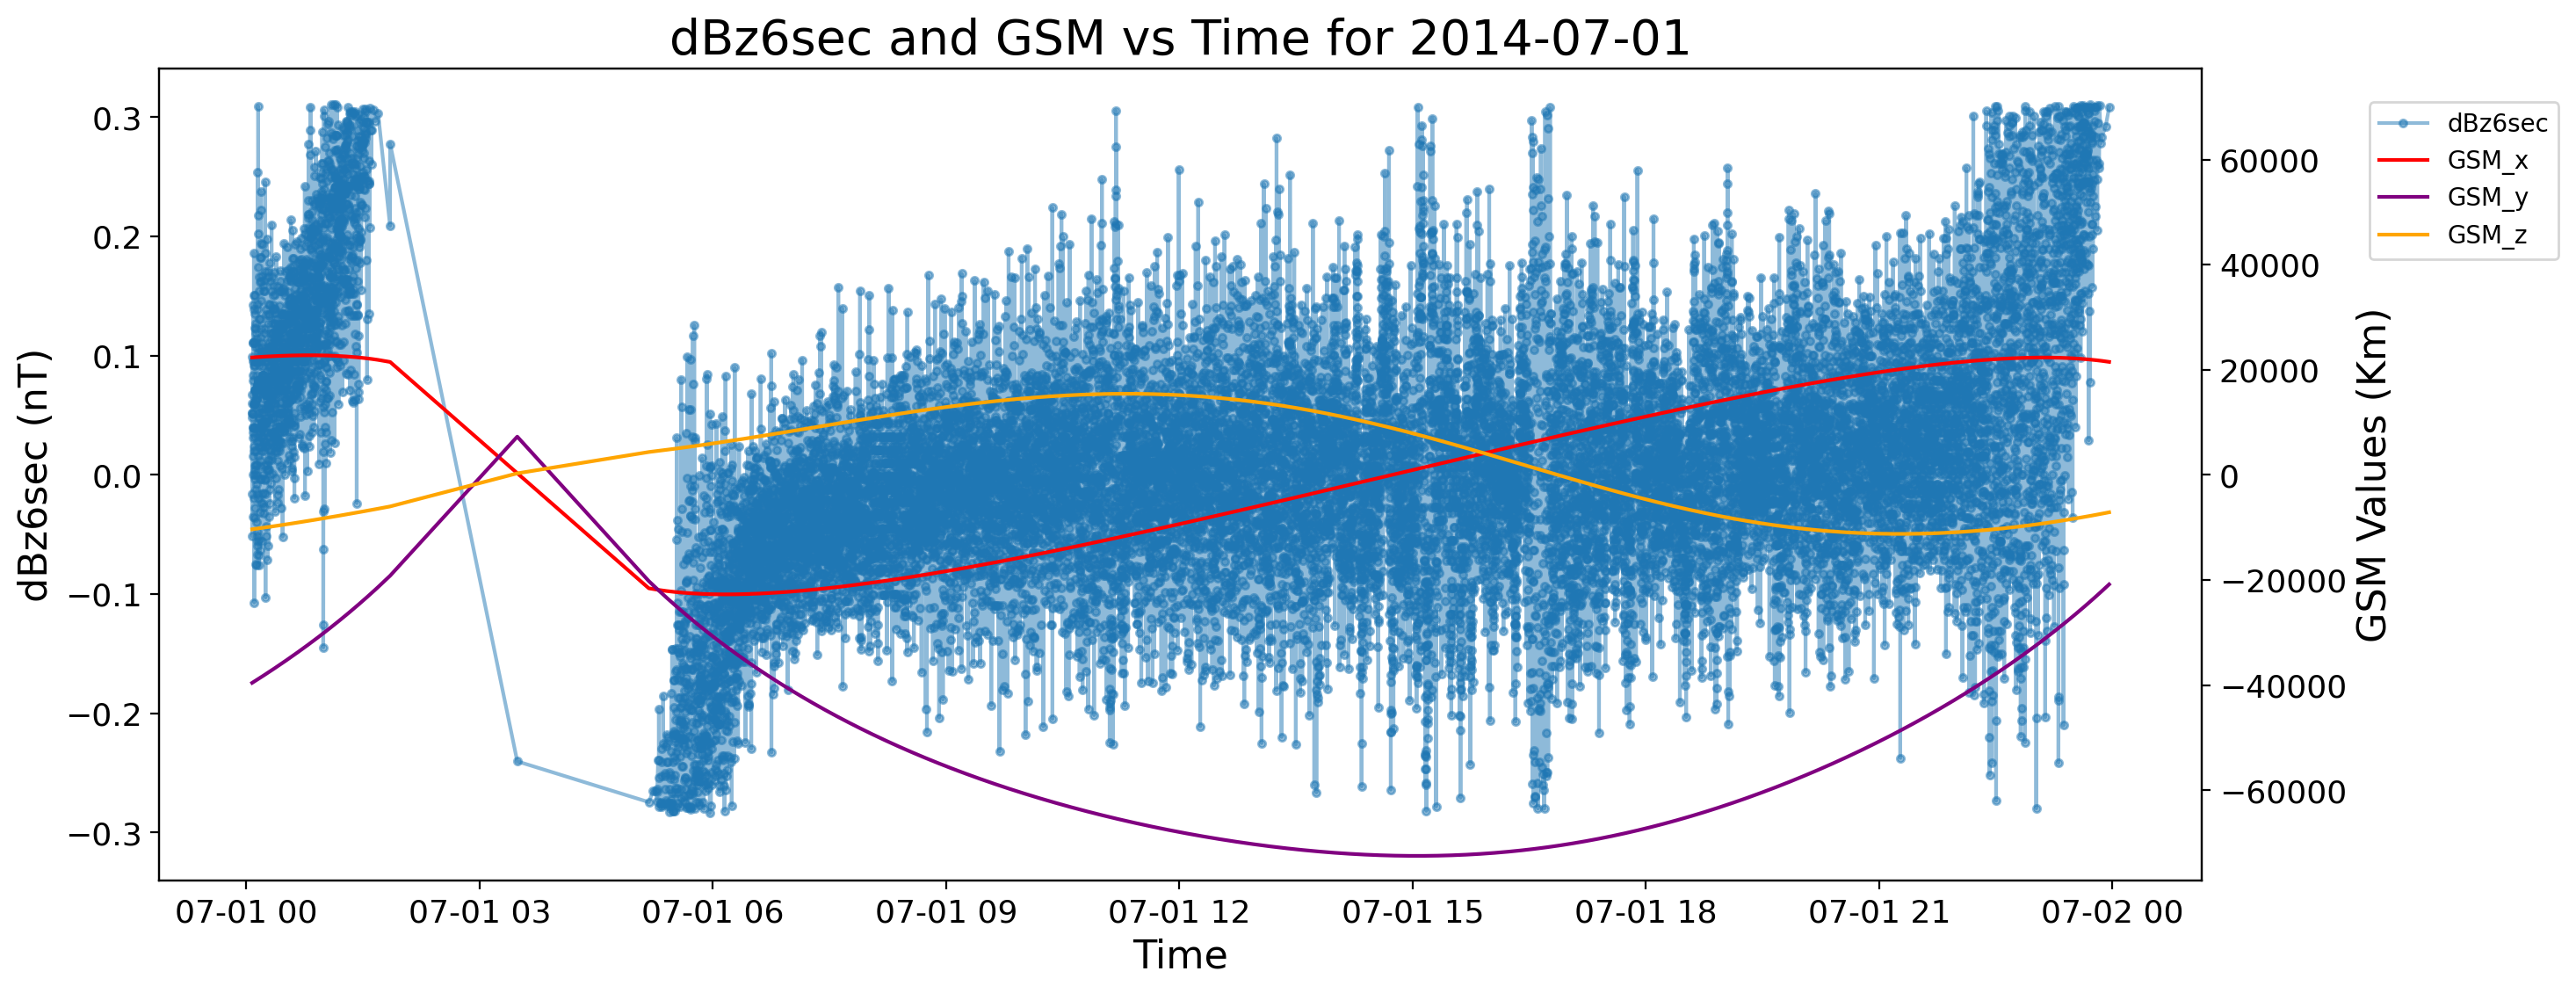

In [14]:
specific_day = '2014-07-01'

mask = final_matrix['Time'].dt.date == pd.to_datetime(specific_day).date()
filtered_data_a = final_matrix[mask]
filtered_data = filter_outliers(filtered_data_a, columns=['dBz6sec'])

fig, ax1 = plt.subplots(figsize=(15, 6), dpi=200)

ax1.plot(filtered_data['Time'], filtered_data['dBz6sec'], color='C0', label='dBz6sec', alpha=0.5, marker='.')
ax1.set_xlabel('Time', fontsize=16)
ax1.set_ylabel('dBz6sec (nT)', fontsize=16)
ax1.tick_params(axis='y', labelsize=13)
ax1.tick_params(axis='x', labelsize=13)

ax2 = ax1.twinx()
ax2.plot(filtered_data['Time'], filtered_data['GSM_x'], label='GSM_x', color='red')
ax2.plot(filtered_data['Time'], filtered_data['GSM_y'], label='GSM_y', color='purple')
ax2.plot(filtered_data['Time'], filtered_data['GSM_z'], label='GSM_z', color='orange')
ax2.set_ylabel('GSM Values (Km)', color='k', fontsize=16)
ax2.tick_params(axis='y', labelcolor='k', labelsize=13)

y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

y1_range = max(abs(y1_min), abs(y1_max))
y2_range = max(abs(y2_min), abs(y2_max))

ax1.set_ylim(-y1_range, y1_range)
ax2.set_ylim(-y2_range, y2_range)

fig.legend(loc='upper right', bbox_to_anchor=(1.04, 0.86))
plt.title(f'dBz6sec and GSM vs Time for {specific_day}', fontsize=20)
plt.show()